In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from glob import glob
import os

### Read logs

In [73]:
total_df = pd.DataFrame()

log_folder = "logs"
files = glob(os.path.join(log_folder, "*.pkl"))
for file in files:
    f_type = file.split("-")[1]
    run = file.split("-")[-1].split(".")[0]
    log_dict = pd.read_pickle(file)
    df = pd.DataFrame(log_dict, index=None)
    df["f"] = f_type
    df["run"] = run
    total_df = pd.concat([total_df, df])
total_df.reset_index(drop=True, inplace=True)

In [74]:
gen = max(total_df["gen"])
print(f"Max generation: {gen}")
total_df.head()

Max generation: 50


,gen,nevals,avg,stddev,min,max,f,run
0,0,30,0.000000e+00,0.000000,0.0,0.000000,f0,7
1,1,26,5.744769e-07,0.000003,0.0,0.000017,f0,7
2,2,30,7.685122e-06,0.000022,0.0,0.000108,f0,7
3,3,27,1.303545e-04,0.000501,0.0,0.002807,f0,7
4,4,26,4.426094e-04,0.000899,0.0,0.002814,f0,7


### Read time

In [75]:
time_data = []

# Time files are saved in the same folder as logs
log_folder = "logs"
files = glob(os.path.join(log_folder, "*_time.txt"))
for file in files:
    f_type = file.split("-")[1]
    run = file.split("-")[-1].split("_")[0]
    with open(file) as f:
        time = f.readline()
    time_data.append([f_type, run, time])

time_df = pd.DataFrame(time_data, columns=["f", "run", "time"])
time_df.time = time_df.time.astype("float")

In [76]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
cmap = matplotlib.colormaps["tab10"]

# Set the colors for each genetic representation
gen_reps = total_df["f"].unique()
color_dict = {mut: cmap(float(i / len(gen_reps))) for i, mut in enumerate(gen_reps)}
color_dict = dict(sorted(color_dict.items()))

### Plot best individuals

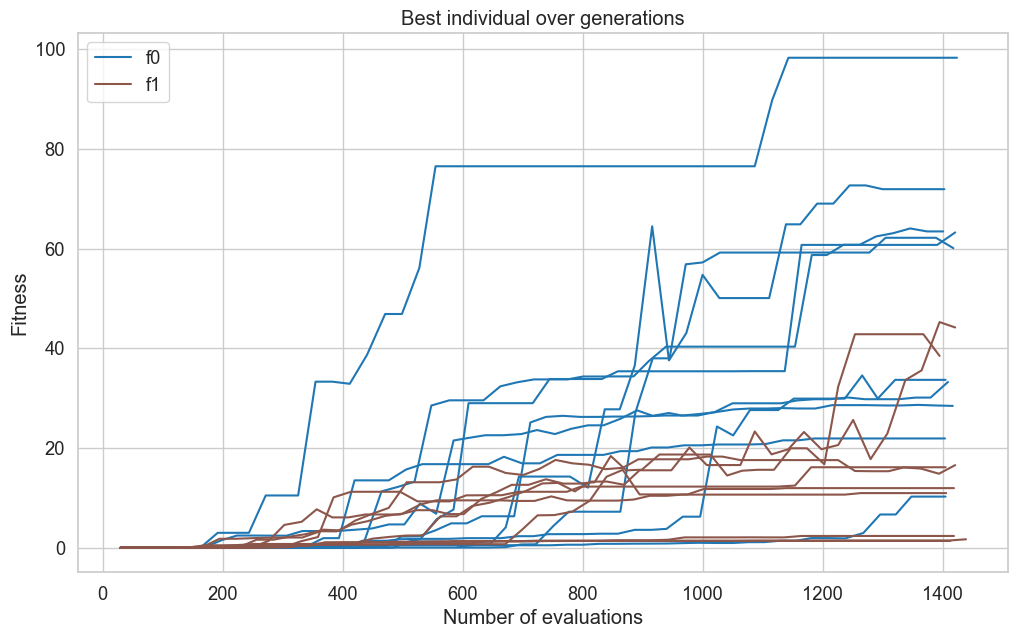

In [77]:
fig, ax = plt.subplots(figsize=(12, 7))

# Group the dataframe by genetic representation
grouped_df = total_df.groupby("f")

# Plot each group as a separate line
for i, (gen_rep, group) in enumerate(grouped_df):
    run_grouped_df = group.groupby("run")
    for j, (run, run_group) in enumerate(run_grouped_df):
        ax.plot(
            run_group["nevals"].cumsum(),
            run_group["max"],
            label=gen_rep,
            color=color_dict[gen_rep],
        )

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Add labels and title
ax.set_xlabel("Number of evaluations")
ax.set_ylabel("Fitness")
ax.set_title("Best individual over generations")

# fig.tight_layout()
# Show the plot
plt.show()
fig.savefig(f"best_individual_{gen}.pdf")

### Plot aggregated

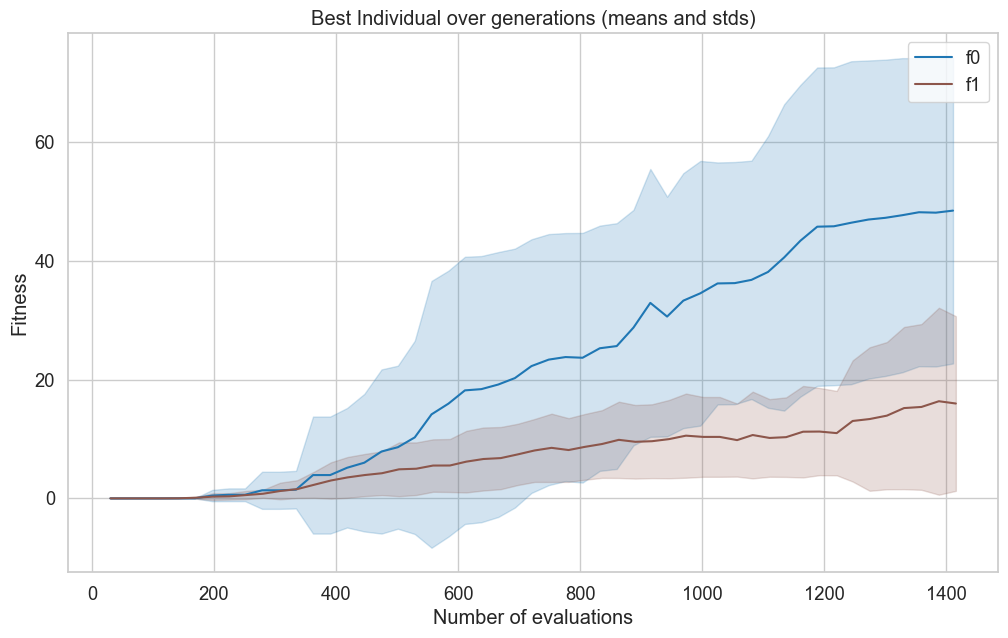

In [80]:
fig, ax = plt.subplots(figsize=(12, 7))

# Group the dataframe by genetic representation
grouped_df = total_df.groupby("f")

# Plot each group as a separate line
for i, (gen_rep, group) in enumerate(grouped_df):
    run_grouped_df = group.groupby("run")
    # Gather the data for each run
    runs_data = []
    nevals_data = []
    for j, (run, run_group) in enumerate(run_grouped_df):
        runs_data.append(run_group["max"].to_numpy())
        nevals_data.append(run_group["nevals"].cumsum().to_numpy())
    # Aggregate the data
    complete_data = np.array(runs_data)
    means = np.mean(complete_data, axis=0)
    stds = np.std(complete_data, axis=0)
    # Average the number of evaluations for x axis
    nevals_data = np.array(nevals_data)
    nevals = np.mean(nevals_data, axis=0)
    # Plot the aggregated data
    ax.plot(nevals, means, label=gen_rep, color=color_dict[gen_rep])
    ax.fill_between(
        nevals, means - stds, means + stds, alpha=0.2, color=color_dict[gen_rep]
    )

# Add labels and title
ax.set_xlabel("Number of evaluations")
ax.set_ylabel("Fitness")
ax.set_title("Best Individual over generations (means and stds)")
plt.legend()

# Show the plot
plt.show()
fig.savefig(f"agg_best_individual_{gen}.pdf")

### Time and HoF fitness boxplots

/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_12035/1038969545.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(gen_rep_labels)
/var/folders/cp/w6zb81516yz3b7dw7m2sgt_80000gn/T/ipykernel_12035/1038969545.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(x='f', y='time', data=time_df,


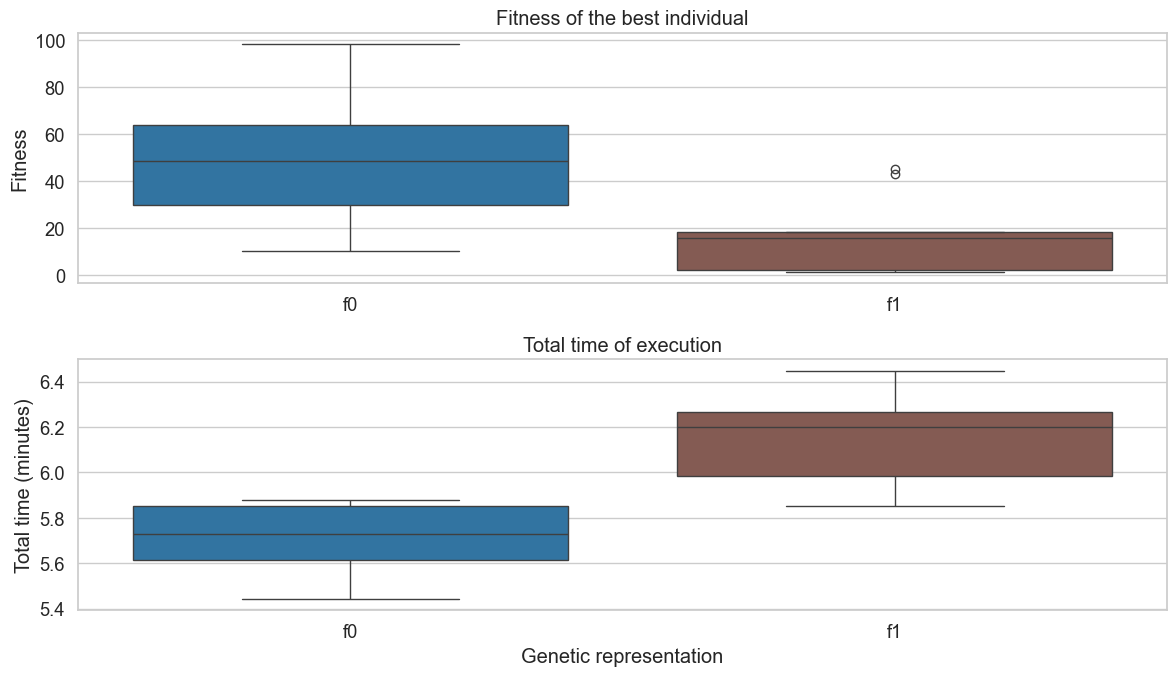

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))

# Group the dataframe by genetic representation
grouped_df = total_df.groupby("f")

gen_rep_data = []
gen_rep_labels = []
for i, (gen_rep, group) in enumerate(grouped_df):
    run_grouped_df = group.groupby("run")
    # Gather the data for each run
    runs_data = []
    for j, (run, run_group) in enumerate(run_grouped_df):
        runs_data.append(run_group["max"].max())
    gen_rep_data.append(runs_data)
    gen_rep_labels.append(gen_rep)
sns.boxplot(gen_rep_data, palette=list(color_dict.values()), ax=ax1)
ax1.set_xticklabels(gen_rep_labels)

time_df["time"] = time_df["time"] / 60
ax2 = sns.boxplot(
    x="f",
    y="time",
    data=time_df,
    order=list(color_dict.keys()),
    palette=list(color_dict.values()),
    ax=ax2,
)

# Add labels and title
ax1.set_ylabel("Fitness")
ax1.set_title("Fitness of the best individual")
ax2.set_xlabel("Genetic representation")
ax2.set_ylabel("Total time (minutes)")
ax2.set_title("Total time of execution")

fig.tight_layout()
# Show the plot
plt.show()
fig.savefig(f"hof_boxplot_fitness_{gen}.pdf")